In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install librosa numpy scikit-learn tensorflow joblib

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, log_loss
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam

In [2]:
# Function to extract features from audio
def extract_features_from_audio(y, sr, fixed_length=40):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=fixed_length)
    mfccs = np.mean(mfccs.T, axis=0)

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma = np.mean(chroma.T, axis=0)

    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    mel = np.mean(mel.T, axis=0)

    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast.T, axis=0)

    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    tonnetz = np.mean(tonnetz.T, axis=0)

    zcr = librosa.feature.zero_crossing_rate(y)
    zcr = np.mean(zcr.T, axis=0)

    rmse = librosa.feature.rms(y=y)
    rmse = np.mean(rmse.T, axis=0)

    # Function to pad or trim features to the fixed length
    def pad_or_trim(feature, length):
        if len(feature) < length:
            return np.pad(feature, (0, length - len(feature)), mode='constant')
        else:
            return feature[:length]

    # Apply padding or trimming to each feature to ensure the fixed length
    mfccs = pad_or_trim(mfccs, fixed_length)
    chroma = pad_or_trim(chroma, fixed_length)
    mel = pad_or_trim(mel, fixed_length)
    contrast = pad_or_trim(contrast, fixed_length)
    tonnetz = pad_or_trim(tonnetz, fixed_length)
    zcr = pad_or_trim(zcr, fixed_length)
    rmse = pad_or_trim(rmse, fixed_length)

    # Concatenate all features into a single feature vector
    return np.concatenate([mfccs, chroma, mel, contrast, tonnetz, zcr, rmse])

In [3]:
# Function to load data and perform data augmentation
def load_data(data_path, fixed_length=40):
    features = []
    labels = []
    for label, class_dir in enumerate(['human', 'ai']):
        class_path = os.path.join(data_path, class_dir)
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            if file_path.endswith('.wav'):
                y, sr = librosa.load(file_path, sr=None)

                # Extracting the original features
                feature = extract_features_from_audio(y, sr, fixed_length=fixed_length)
                features.append(feature)
                labels.append(label)

                # Data augmentation: adding slight noise
                noise = np.random.normal(0, 0.005, y.shape)
                y_noise = y + noise
                features.append(extract_features_from_audio(y_noise, sr, fixed_length=fixed_length))
                labels.append(label)

                # Data augmentation: shifting time
                shift_range = int(0.1 * len(y))
                y_shift = np.roll(y, shift_range)
                features.append(extract_features_from_audio(y_shift, sr, fixed_length=fixed_length))
                labels.append(label)

                # Data augmentation: pitch shifting slightly
                y_pitch_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
                features.append(extract_features_from_audio(y_pitch_shift, sr, fixed_length=fixed_length))
                labels.append(label)

                # Data augmentation: changing speed slightly
                y_stretch = librosa.effects.time_stretch(y, rate=1.1)
                features.append(extract_features_from_audio(y_stretch, sr, fixed_length=fixed_length))
                labels.append(label)

    return np.array(features), np.array(labels)

In [ ]:
data_path = '/content/drive/MyDrive/dataset'
X, y = load_data(data_path)

In [4]:
import pickle
import numpy as np

# Load data fitur dan label
with open('processed_features.pkl', 'rb') as f:
    X = pickle.load(f)

with open('processed_labels.pkl', 'rb') as f:
    y = pickle.load(f)

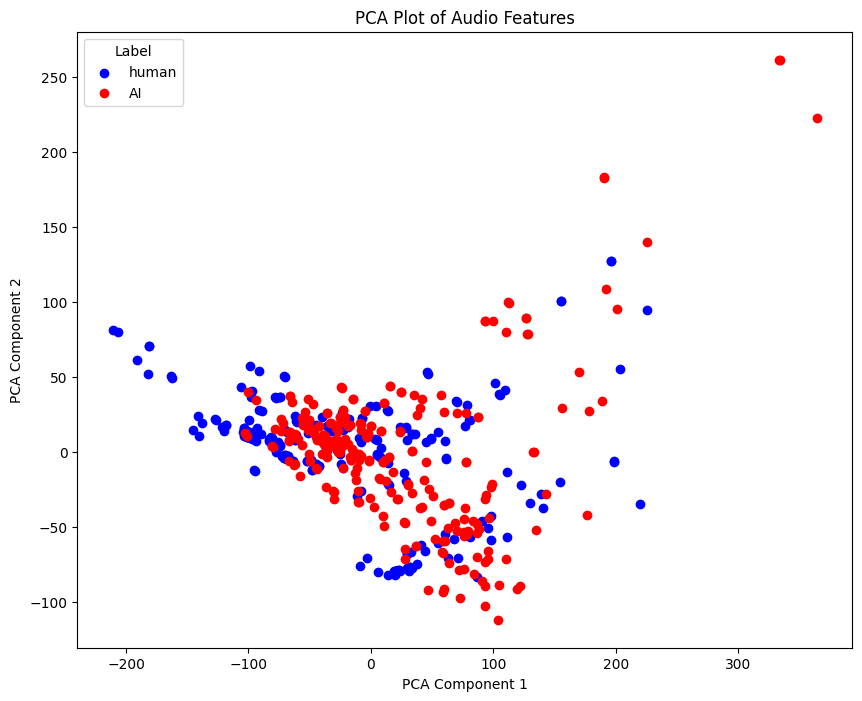

In [ ]:
from sklearn.decomposition import PCA

def plot_pca(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='blue', label='human')
    plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='red', label='AI')
    plt.title('PCA Plot of Audio Features')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Label')
    plt.show()

plot_pca(X, y)

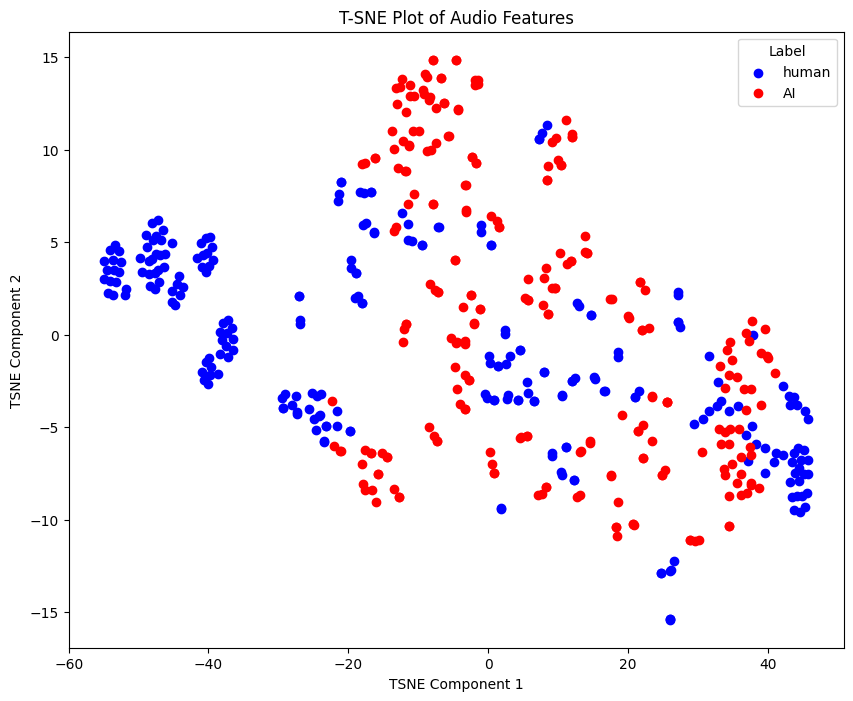

In [ ]:
from sklearn.manifold import TSNE

def plot_tsne_manual(X, y):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    # Plot manual berdasarkan label
    plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], color='blue', label='human')
    plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], color='red', label='AI')
    plt.title('T-SNE Plot of Audio Features')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Label')
    plt.show()

plot_tsne_manual(X, y)

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Misalkan kita mengambil rata-rata fitur untuk masing-masing kelas
human_features = X[y == 0]
ai_features = X[y == 1]

human_mean = np.mean(human_features, axis=0)
ai_mean = np.mean(ai_features, axis=0)

# Menghitung cosine similarity antara rata-rata fitur human dan AI
similarity = cosine_similarity([human_mean], [ai_mean])
print(f"Cosine Similarity between Human and AI features: {similarity[0][0]:.2f}")

Cosine Similarity between Human and AI features: 0.99


In [6]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure that the split reflects the original distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Reshape data for CNN input
X_train_cnn = X_train[..., np.newaxis, np.newaxis]
X_test_cnn = X_test[..., np.newaxis, np.newaxis]

# Convert labels to one-hot encoding for CNN
y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)

In [8]:
def create_and_compile_cnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, kernel_size=(3, 1), activation='relu'),
        MaxPooling2D(pool_size=(2, 1)),
        BatchNormalization(),

        Conv2D(64, kernel_size=(3, 1), activation='relu'),
        MaxPooling2D(pool_size=(2, 1)),
        BatchNormalization(),

        Conv2D(128, kernel_size=(3, 1), activation='relu'),
        MaxPooling2D(pool_size=(2, 1)),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cnn_accuracies = []
cnn_aucs = []
fold_confusion_matrices = []  # List to store confusion matrices for each fold

# Define model outside loop to avoid retracing
cnn_model = create_and_compile_cnn_model(X_train_cnn.shape[1:])

for train_index, val_index in skf.split(X_train_cnn, y_train):
    # Reset model weights for each fold
    cnn_model.set_weights(cnn_model.get_weights())

    X_train_fold, X_val_fold = X_train_cnn[train_index], X_train_cnn[val_index]
    y_train_fold, y_val_fold = y_train_cnn[train_index], y_train_cnn[val_index]

    history_cnn = cnn_model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
                                epochs=50, batch_size=16, verbose=0)

    cnn_loss, cnn_accuracy = cnn_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    cnn_accuracies.append(cnn_accuracy)
    cnn_aucs.append(roc_auc_score(y_val_fold, cnn_model.predict(X_val_fold)))

    # Make predictions and calculate confusion matrix for this fold
    y_pred_val = cnn_model.predict(X_val_fold)
    y_pred_labels_val = np.argmax(y_pred_val, axis=1)
    y_val_labels = np.argmax(y_val_fold, axis=1)

    fold_confusion_matrix = confusion_matrix(y_val_labels, y_pred_labels_val)
    fold_confusion_matrices.append(fold_confusion_matrix)

# Final evaluation on the test set
y_pred_cnn = cnn_model.predict(X_test_cnn)

# Convert one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred_cnn, axis=1)
y_test_labels = np.argmax(y_test_cnn, axis=1)

# Calculate Accuracy
cnn_test_accuracy = accuracy_score(y_test_labels, y_pred_labels)

# Calculate Precision, Recall, F1-Score
cnn_precision = precision_score(y_test_labels, y_pred_labels)
cnn_recall = recall_score(y_test_labels, y_pred_labels)
cnn_f1 = f1_score(y_test_labels, y_pred_labels)

# Calculate Matthews Correlation Coefficient (MCC)
cnn_mcc = matthews_corrcoef(y_test_labels, y_pred_labels)

# Calculate Log Loss
cnn_log_loss = log_loss(y_test_cnn, y_pred_cnn)

# Calculate AUC score
cnn_test_auc = roc_auc_score(y_test_cnn, y_pred_cnn)

# Generate confusion matrix
cnn_confusion_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Print confusion matrices for each fold
print("Confusion Matrices for Each Fold:")
for i, cm in enumerate(fold_confusion_matrices):
    print(f"Fold {i+1} Confusion Matrix:")
    print(cm)

print("Final Confusion Matrix:")
print(cnn_confusion_matrix)

# Print all the results
print(f"Final CNN Test Accuracy: {cnn_test_accuracy:.2f}")
print(f"Final CNN Test Precision: {cnn_precision:.2f}")
print(f"Final CNN Test Recall: {cnn_recall:.2f}")
print(f"Final CNN Test F1-Score: {cnn_f1:.2f}")
print(f"Final CNN Test MCC: {cnn_mcc:.2f}")
print(f"Final CNN Test Log Loss: {cnn_log_loss:.2f}")
print(f"Final CNN Test AUC: {cnn_test_auc:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Confusion Matrices for Each Fold:
Fold 1 Confusion Matrix:
[[40  0]
 [ 0 40]]
Fold 2 Confusion Matrix:
[[35  5]
 [ 2 38]]
Fold 3 Confusion Matrix:
[[40  0]
 [ 0 40]]
Fold 4 Confusion Matrix:
[[40  0]
 [ 0 40]]
Fold 5 Confusion Matrix:
[[40  0]
 [ 0 40]]
Final Confusion Matrix:
[[50  0]
 [ 1 49]]
Final CNN Test Accuracy: 0.99
Final CNN Test Precision: 1.00
Final CNN Test Recall: 0.98
Final CNN Test F1-Score: 0.99
Final CNN Test MCC: 0.98
Final CNN Test Log Loss: 0.04
Final CNN Test AUC: 1.00


In [10]:
svm_model_no_tuning = SVC(probability=True)
svm_accuracies = []
svm_precisions = []
svm_recalls = []
svm_f1_scores = []
svm_mccs = []
svm_log_losses = []
svm_aucs = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    svm_model_no_tuning.fit(X_train_fold, y_train_fold)
    svm_pred_val = svm_model_no_tuning.predict(X_val_fold)
    svm_pred_proba_val = svm_model_no_tuning.predict_proba(X_val_fold)[:, 1]

    # Evaluate metrics for this fold
    svm_accuracies.append(accuracy_score(y_val_fold, svm_pred_val))
    svm_precisions.append(precision_score(y_val_fold, svm_pred_val))
    svm_recalls.append(recall_score(y_val_fold, svm_pred_val))
    svm_f1_scores.append(f1_score(y_val_fold, svm_pred_val))
    svm_mccs.append(matthews_corrcoef(y_val_fold, svm_pred_val))
    svm_log_losses.append(log_loss(y_val_fold, svm_pred_proba_val))
    svm_aucs.append(roc_auc_score(y_val_fold, svm_pred_proba_val))

    # Confusion matrix for this fold
    fold_confusion_matrix = confusion_matrix(y_val_fold, svm_pred_val)
    print(f"SVM Confusion Matrix for Fold:\n{fold_confusion_matrix}\n")

# Final evaluation on the test set
svm_pred_test = svm_model_no_tuning.predict(X_test)
svm_pred_proba_test = svm_model_no_tuning.predict_proba(X_test)[:, 1]

# Calculate all required metrics on the test set
svm_test_accuracy = accuracy_score(y_test, svm_pred_test)
svm_test_precision = precision_score(y_test, svm_pred_test)
svm_test_recall = recall_score(y_test, svm_pred_test)
svm_test_f1 = f1_score(y_test, svm_pred_test)
svm_test_mcc = matthews_corrcoef(y_test, svm_pred_test)
svm_test_log_loss = log_loss(y_test, svm_pred_proba_test)
svm_test_auc = roc_auc_score(y_test, svm_pred_proba_test)
svm_test_confusion_matrix = confusion_matrix(y_test, svm_pred_test)

# Print metrics
print(f"SVM Confusion Matrix on Test Set:\n{svm_test_confusion_matrix}\n")
print(f"SVM Test Accuracy: {svm_test_accuracy:.2f}")
print(f"SVM Test Precision: {svm_test_precision:.2f}")
print(f"SVM Test Recall: {svm_test_recall:.2f}")
print(f"SVM Test F1-Score: {svm_test_f1:.2f}")
print(f"SVM Test MCC: {svm_test_mcc:.2f}")
print(f"SVM Test Log Loss: {svm_test_log_loss:.2f}")
print(f"SVM Test AUC: {svm_test_auc:.2f}")

SVM Confusion Matrix for Fold:
[[37  3]
 [ 0 40]]

SVM Confusion Matrix for Fold:
[[36  4]
 [ 0 40]]

SVM Confusion Matrix for Fold:
[[40  0]
 [ 0 40]]

SVM Confusion Matrix for Fold:
[[35  5]
 [ 2 38]]

SVM Confusion Matrix for Fold:
[[37  3]
 [ 2 38]]

SVM Confusion Matrix on Test Set:
[[49  1]
 [ 1 49]]

SVM Test Accuracy: 0.98
SVM Test Precision: 0.98
SVM Test Recall: 0.98
SVM Test F1-Score: 0.98
SVM Test MCC: 0.96
SVM Test Log Loss: 0.07
SVM Test AUC: 1.00


In [11]:
rf_model_no_tuning = RandomForestClassifier()
rf_accuracies = []
rf_precisions = []
rf_recalls = []
rf_f1_scores = []
rf_mccs = []
rf_log_losses = []
rf_aucs = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    rf_model_no_tuning.fit(X_train_fold, y_train_fold)
    rf_pred_val = rf_model_no_tuning.predict(X_val_fold)
    rf_pred_proba_val = rf_model_no_tuning.predict_proba(X_val_fold)[:, 1]

    # Evaluate metrics for this fold
    rf_accuracies.append(accuracy_score(y_val_fold, rf_pred_val))
    rf_precisions.append(precision_score(y_val_fold, rf_pred_val))
    rf_recalls.append(recall_score(y_val_fold, rf_pred_val))
    rf_f1_scores.append(f1_score(y_val_fold, rf_pred_val))
    rf_mccs.append(matthews_corrcoef(y_val_fold, rf_pred_val))
    rf_log_losses.append(log_loss(y_val_fold, rf_pred_proba_val))
    rf_aucs.append(roc_auc_score(y_val_fold, rf_pred_proba_val))

    # Confusion matrix for this fold
    fold_confusion_matrix = confusion_matrix(y_val_fold, rf_pred_val)
    print(f"Random Forest Confusion Matrix for Fold:\n{fold_confusion_matrix}\n")

# Final evaluation on the test set
rf_pred_test = rf_model_no_tuning.predict(X_test)
rf_pred_proba_test = rf_model_no_tuning.predict_proba(X_test)[:, 1]

# Calculate all required metrics on the test set
rf_test_accuracy = accuracy_score(y_test, rf_pred_test)
rf_test_precision = precision_score(y_test, rf_pred_test)
rf_test_recall = recall_score(y_test, rf_pred_test)
rf_test_f1 = f1_score(y_test, rf_pred_test)
rf_test_mcc = matthews_corrcoef(y_test, rf_pred_test)
rf_test_log_loss = log_loss(y_test, rf_pred_proba_test)
rf_test_auc = roc_auc_score(y_test, rf_pred_proba_test)
rf_test_confusion_matrix = confusion_matrix(y_test, rf_pred_test)

# Print metrics
print(f"Random Forest Confusion Matrix on Test Set:\n{rf_test_confusion_matrix}\n")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.2f}")
print(f"Random Forest Test Precision: {rf_test_precision:.2f}")
print(f"Random Forest Test Recall: {rf_test_recall:.2f}")
print(f"Random Forest Test F1-Score: {rf_test_f1:.2f}")
print(f"Random Forest Test MCC: {rf_test_mcc:.2f}")
print(f"Random Forest Test Log Loss: {rf_test_log_loss:.2f}")
print(f"Random Forest Test AUC: {rf_test_auc:.2f}")

Random Forest Confusion Matrix for Fold:
[[35  5]
 [ 0 40]]

Random Forest Confusion Matrix for Fold:
[[32  8]
 [ 0 40]]

Random Forest Confusion Matrix for Fold:
[[36  4]
 [ 2 38]]

Random Forest Confusion Matrix for Fold:
[[36  4]
 [ 2 38]]

Random Forest Confusion Matrix for Fold:
[[35  5]
 [ 1 39]]

Random Forest Confusion Matrix on Test Set:
[[44  6]
 [ 1 49]]

Random Forest Test Accuracy: 0.93
Random Forest Test Precision: 0.89
Random Forest Test Recall: 0.98
Random Forest Test F1-Score: 0.93
Random Forest Test MCC: 0.86
Random Forest Test Log Loss: 0.22
Random Forest Test AUC: 0.99


In [15]:
meta_learner = LogisticRegression()

meta_accuracies = []
meta_precisions = []
meta_recalls = []
meta_f1_scores = []
meta_mccs = []
meta_log_losses = []
meta_aucs = []

# Stratified K-Fold setup
fold_idx = 1  # Fold counter

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Predictions from base models (stacking)
    svm_pred_train = svm_model_no_tuning.predict_proba(X_train_fold)[:, 1]
    cnn_pred_train = cnn_model.predict(X_train_cnn[train_index])[:, 1]

    X_meta_train = np.column_stack((svm_pred_train, cnn_pred_train))
    meta_learner.fit(X_meta_train, y_train_fold)

    # Validation set predictions
    svm_pred_val = svm_model_no_tuning.predict_proba(X_val_fold)[:, 1]
    cnn_pred_val = cnn_model.predict(X_train_cnn[val_index])[:, 1]

    X_meta_val = np.column_stack((svm_pred_val, cnn_pred_val))
    meta_pred_val = meta_learner.predict(X_meta_val)
    meta_pred_proba_val = meta_learner.predict_proba(X_meta_val)[:, 1]

    # Evaluate metrics for this fold
    meta_accuracies.append(accuracy_score(y_val_fold, meta_pred_val))
    meta_precisions.append(precision_score(y_val_fold, meta_pred_val))
    meta_recalls.append(recall_score(y_val_fold, meta_pred_val))
    meta_f1_scores.append(f1_score(y_val_fold, meta_pred_val))
    meta_mccs.append(matthews_corrcoef(y_val_fold, meta_pred_val))
    meta_log_losses.append(log_loss(y_val_fold, meta_pred_proba_val))
    meta_aucs.append(roc_auc_score(y_val_fold, meta_pred_proba_val))

    # Confusion matrix for this fold
    fold_confusion_matrix = confusion_matrix(y_val_fold, meta_pred_val)
    print(f"Confusion Matrix for Fold {fold_idx}:\n{fold_confusion_matrix}\n")
    fold_idx += 1

# Final evaluation on the test set
cnn_pred_test = cnn_model.predict(X_test_cnn)[:, 1]  # CNN probabilities for positive class
svm_pred_test = svm_model_no_tuning.predict_proba(X_test)[:, 1]  # SVM probabilities for positive class

# Combine base model predictions as input to meta-learner
meta_input_test = np.column_stack((svm_pred_test, cnn_pred_test))

# Meta-learner predictions on test set
meta_pred_test = meta_learner.predict(meta_input_test)
meta_pred_proba_test = meta_learner.predict_proba(meta_input_test)[:, 1]

# Calculate all required metrics on the test set
meta_test_accuracy = accuracy_score(y_test, meta_pred_test)
meta_test_precision = precision_score(y_test, meta_pred_test)
meta_test_recall = recall_score(y_test, meta_pred_test)
meta_test_f1 = f1_score(y_test, meta_pred_test)
meta_test_mcc = matthews_corrcoef(y_test, meta_pred_test)
meta_test_log_loss = log_loss(y_test, meta_pred_proba_test)
meta_test_auc = roc_auc_score(y_test, meta_pred_proba_test)
meta_test_confusion_matrix = confusion_matrix(y_test, meta_pred_test)

# Print confusion matrix and metrics
print(f"Meta-Learner Confusion Matrix on Test Set:\n{meta_test_confusion_matrix}\n")
print(f"Meta-Learner Accuracy: {meta_test_accuracy:.2f}")
print(f"Meta-Learner Precision: {meta_test_precision:.2f}")
print(f"Meta-Learner Recall: {meta_test_recall:.2f}")
print(f"Meta-Learner F1-Score: {meta_test_f1:.2f}")
print(f"Meta-Learner MCC: {meta_test_mcc:.2f}")
print(f"Meta-Learner Log Loss: {meta_test_log_loss:.2f}")
print(f"Meta-Learner AUC: {meta_test_auc:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Confusion Matrix for Fold 1:
[[40  0]
 [ 0 40]]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Confusion Matrix for Fold 2:
[[40  0]
 [ 0 40]]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Confusion Matrix for Fold 3:
[[40  0]
 [ 0 40]]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Confusion Matrix for Fold 4:
[[40  0]
 [ 0 40]]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Confusion Matrix for Fold 5:
[[40  0]
 [ 0 40]]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Meta-Learner Confusion Matrix on Test Set:
[[50  0]
 [ 1 49]]

Meta-Learner Accuracy: 0.99
Meta-Learner Precision: 1.00
Meta-Learner Recall: 0.98
Meta-Learner F1-Score: 0.99
Meta-Learner MCC: 0.98
Meta-Learner Log Loss: 0.04
Meta-Learner AUC: 1.00


In [14]:
meta_learner = LogisticRegression()

meta_accuracies = []
meta_precisions = []
meta_recalls = []
meta_f1_scores = []
meta_mccs = []
meta_log_losses = []
meta_aucs = []

# Stratified K-Fold setup
fold_idx = 1  # Fold counter

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Predictions from base models (stacking)
    rf_pred_train = rf_model_no_tuning.predict_proba(X_train_fold)[:, 1]
    cnn_pred_train = cnn_model.predict(X_train_cnn[train_index])[:, 1]

    X_meta_train = np.column_stack((rf_pred_train, cnn_pred_train))
    meta_learner.fit(X_meta_train, y_train_fold)

    # Validation set predictions
    rf_pred_val = rf_model_no_tuning.predict_proba(X_val_fold)[:, 1]
    cnn_pred_val = cnn_model.predict(X_train_cnn[val_index])[:, 1]

    X_meta_val = np.column_stack((rf_pred_val, cnn_pred_val))
    meta_pred_val = meta_learner.predict(X_meta_val)
    meta_pred_proba_val = meta_learner.predict_proba(X_meta_val)[:, 1]

    # Evaluate metrics for this fold
    meta_accuracies.append(accuracy_score(y_val_fold, meta_pred_val))
    meta_precisions.append(precision_score(y_val_fold, meta_pred_val))
    meta_recalls.append(recall_score(y_val_fold, meta_pred_val))
    meta_f1_scores.append(f1_score(y_val_fold, meta_pred_val))
    meta_mccs.append(matthews_corrcoef(y_val_fold, meta_pred_val))
    meta_log_losses.append(log_loss(y_val_fold, meta_pred_proba_val))
    meta_aucs.append(roc_auc_score(y_val_fold, meta_pred_proba_val))

    # Confusion matrix for this fold
    fold_confusion_matrix = confusion_matrix(y_val_fold, meta_pred_val)
    print(f"Confusion Matrix for Fold {fold_idx}:\n{fold_confusion_matrix}\n")
    fold_idx += 1

# Final evaluation on the test set
cnn_pred_test = cnn_model.predict(X_test_cnn)[:, 1]  # CNN probabilities for positive class
rf_pred_test = rf_model_no_tuning.predict_proba(X_test)[:, 1]  # RF probabilities for positive class

# Combine base model predictions as input to meta-learner
meta_input_test = np.column_stack((rf_pred_test, cnn_pred_test))

# Meta-learner predictions on test set
meta_pred_test = meta_learner.predict(meta_input_test)
meta_pred_proba_test = meta_learner.predict_proba(meta_input_test)[:, 1]

# Calculate all required metrics on the test set
meta_test_accuracy = accuracy_score(y_test, meta_pred_test)
meta_test_precision = precision_score(y_test, meta_pred_test)
meta_test_recall = recall_score(y_test, meta_pred_test)
meta_test_f1 = f1_score(y_test, meta_pred_test)
meta_test_mcc = matthews_corrcoef(y_test, meta_pred_test)
meta_test_log_loss = log_loss(y_test, meta_pred_proba_test)
meta_test_auc = roc_auc_score(y_test, meta_pred_proba_test)
meta_test_confusion_matrix = confusion_matrix(y_test, meta_pred_test)

# Print confusion matrix and metrics
print(f"Meta-Learner Confusion Matrix on Test Set:\n{meta_test_confusion_matrix}\n")
print(f"Meta-Learner Accuracy: {meta_test_accuracy:.2f}")
print(f"Meta-Learner Precision: {meta_test_precision:.2f}")
print(f"Meta-Learner Recall: {meta_test_recall:.2f}")
print(f"Meta-Learner F1-Score: {meta_test_f1:.2f}")
print(f"Meta-Learner MCC: {meta_test_mcc:.2f}")
print(f"Meta-Learner Log Loss: {meta_test_log_loss:.2f}")
print(f"Meta-Learner AUC: {meta_test_auc:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Confusion Matrix for Fold 1:
[[40  0]
 [ 0 40]]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Confusion Matrix for Fold 2:
[[40  0]
 [ 0 40]]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Confusion Matrix for Fold 3:
[[40  0]
 [ 0 40]]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Confusion Matrix for Fold 4:
[[40  0]
 [ 0 40]]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Confusion Matrix for Fold 5:
[[40  0]
 [ 0 40]]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Meta-Learner Confusion Matrix on Test Set:
[[50  0]
 [ 1 49]]

Meta-Learner Accuracy: 0.99
Meta-Learner Precision: 1.00
Meta-Learner Recall: 0.98
Meta-Learner F1-Score: 0.99
Meta-Learner MCC: 0.98
Meta-Learner Log Loss: 0.06
Meta-Learner AUC: 1.00


In [13]:
meta_learner = LogisticRegression()

meta_accuracies = []
meta_precisions = []
meta_recalls = []
meta_f1_scores = []
meta_mccs = []
meta_log_losses = []
meta_aucs = []

# Stratified K-Fold setup
fold_idx = 1  # Fold counter

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Predictions from base models (stacking)
    svm_pred_train = svm_model_no_tuning.predict_proba(X_train_fold)[:, 1]
    rf_pred_train = rf_model_no_tuning.predict_proba(X_train_fold)[:, 1]

    X_meta_train = np.column_stack((svm_pred_train, rf_pred_train))
    meta_learner.fit(X_meta_train, y_train_fold)

    # Validation set predictions
    svm_pred_val = svm_model_no_tuning.predict_proba(X_val_fold)[:, 1]
    rf_pred_val = rf_model_no_tuning.predict_proba(X_val_fold)[:, 1]

    X_meta_val = np.column_stack((svm_pred_val, rf_pred_val))
    meta_pred_val = meta_learner.predict(X_meta_val)
    meta_pred_proba_val = meta_learner.predict_proba(X_meta_val)[:, 1]

    # Evaluate metrics for this fold
    meta_accuracies.append(accuracy_score(y_val_fold, meta_pred_val))
    meta_precisions.append(precision_score(y_val_fold, meta_pred_val))
    meta_recalls.append(recall_score(y_val_fold, meta_pred_val))
    meta_f1_scores.append(f1_score(y_val_fold, meta_pred_val))
    meta_mccs.append(matthews_corrcoef(y_val_fold, meta_pred_val))
    meta_log_losses.append(log_loss(y_val_fold, meta_pred_proba_val))
    meta_aucs.append(roc_auc_score(y_val_fold, meta_pred_proba_val))

    # Confusion matrix for this fold
    fold_confusion_matrix = confusion_matrix(y_val_fold, meta_pred_val)
    print(f"Confusion Matrix for Fold {fold_idx}:\n{fold_confusion_matrix}\n")
    fold_idx += 1

# Final evaluation on the test set
svm_pred_test = svm_model_no_tuning.predict_proba(X_test)[:, 1]  # SVM probabilities for positive class
rf_pred_test = rf_model_no_tuning.predict_proba(X_test)[:, 1]  # RF probabilities for positive class

# Combine base model predictions as input to meta-learner
meta_input_test = np.column_stack((svm_pred_test, rf_pred_test))

# Meta-learner predictions on test set
meta_pred_test = meta_learner.predict(meta_input_test)
meta_pred_proba_test = meta_learner.predict_proba(meta_input_test)[:, 1]

# Calculate all required metrics on the test set
meta_test_accuracy = accuracy_score(y_test, meta_pred_test)
meta_test_precision = precision_score(y_test, meta_pred_test)
meta_test_recall = recall_score(y_test, meta_pred_test)
meta_test_f1 = f1_score(y_test, meta_pred_test)
meta_test_mcc = matthews_corrcoef(y_test, meta_pred_test)
meta_test_log_loss = log_loss(y_test, meta_pred_proba_test)
meta_test_auc = roc_auc_score(y_test, meta_pred_proba_test)
meta_test_confusion_matrix = confusion_matrix(y_test, meta_pred_test)

# Print confusion matrix and metrics
print(f"Meta-Learner Confusion Matrix on Test Set:\n{meta_test_confusion_matrix}\n")
print(f"Meta-Learner Accuracy: {meta_test_accuracy:.2f}")
print(f"Meta-Learner Precision: {meta_test_precision:.2f}")
print(f"Meta-Learner Recall: {meta_test_recall:.2f}")
print(f"Meta-Learner F1-Score: {meta_test_f1:.2f}")
print(f"Meta-Learner MCC: {meta_test_mcc:.2f}")
print(f"Meta-Learner Log Loss: {meta_test_log_loss:.2f}")
print(f"Meta-Learner AUC: {meta_test_auc:.2f}")

Confusion Matrix for Fold 1:
[[40  0]
 [ 0 40]]

Confusion Matrix for Fold 2:
[[40  0]
 [ 0 40]]

Confusion Matrix for Fold 3:
[[40  0]
 [ 0 40]]

Confusion Matrix for Fold 4:
[[40  0]
 [ 0 40]]

Confusion Matrix for Fold 5:
[[38  2]
 [ 2 38]]

Meta-Learner Confusion Matrix on Test Set:
[[49  1]
 [ 1 49]]

Meta-Learner Accuracy: 0.98
Meta-Learner Precision: 0.98
Meta-Learner Recall: 0.98
Meta-Learner F1-Score: 0.98
Meta-Learner MCC: 0.96
Meta-Learner Log Loss: 0.08
Meta-Learner AUC: 1.00


In [17]:
meta_learner = LogisticRegression()

meta_accuracies = []
meta_precisions = []
meta_recalls = []
meta_f1_scores = []
meta_mccs = []
meta_log_losses = []
meta_aucs = []

# Stratified K-Fold setup
fold_idx = 1  # Fold counter

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Predictions from base models (stacking)
    svm_pred_train = svm_model_no_tuning.predict_proba(X_train_fold)[:, 1]
    rf_pred_train = rf_model_no_tuning.predict_proba(X_train_fold)[:, 1]
    cnn_pred_train = cnn_model.predict(X_train_cnn[train_index])[:, 1]

    X_meta_train = np.column_stack((svm_pred_train, rf_pred_train, cnn_pred_train))
    meta_learner.fit(X_meta_train, y_train_fold)

    # Validation set predictions
    svm_pred_val = svm_model_no_tuning.predict_proba(X_val_fold)[:, 1]
    rf_pred_val = rf_model_no_tuning.predict_proba(X_val_fold)[:, 1]
    cnn_pred_val = cnn_model.predict(X_train_cnn[val_index])[:, 1]

    X_meta_val = np.column_stack((svm_pred_val, rf_pred_val, cnn_pred_val))
    meta_pred_val = meta_learner.predict(X_meta_val)
    meta_pred_proba_val = meta_learner.predict_proba(X_meta_val)[:, 1]

    # Evaluate metrics for this fold
    meta_accuracies.append(accuracy_score(y_val_fold, meta_pred_val))
    meta_precisions.append(precision_score(y_val_fold, meta_pred_val))
    meta_recalls.append(recall_score(y_val_fold, meta_pred_val))
    meta_f1_scores.append(f1_score(y_val_fold, meta_pred_val))
    meta_mccs.append(matthews_corrcoef(y_val_fold, meta_pred_val))
    meta_log_losses.append(log_loss(y_val_fold, meta_pred_proba_val))
    meta_aucs.append(roc_auc_score(y_val_fold, meta_pred_proba_val))

    # Confusion matrix for this fold
    fold_confusion_matrix = confusion_matrix(y_val_fold, meta_pred_val)
    print(f"Confusion Matrix for Fold {fold_idx}:\n{fold_confusion_matrix}\n")
    fold_idx += 1

# Final evaluation on the test set
cnn_pred_test = cnn_model.predict(X_test_cnn)[:, 1]  # CNN probabilities for positive class
svm_pred_test = svm_model_no_tuning.predict_proba(X_test)[:, 1]  # SVM probabilities for positive class
rf_pred_test = rf_model_no_tuning.predict_proba(X_test)[:, 1]  # RF probabilities for positive class

# Combine base model predictions as input to meta-learner
meta_input_test = np.column_stack((svm_pred_test, rf_pred_test, cnn_pred_test))

# Meta-learner predictions on test set
meta_pred_test = meta_learner.predict(meta_input_test)
meta_pred_proba_test = meta_learner.predict_proba(meta_input_test)[:, 1]

# Calculate all required metrics on the test set
meta_test_accuracy = accuracy_score(y_test, meta_pred_test)
meta_test_precision = precision_score(y_test, meta_pred_test)
meta_test_recall = recall_score(y_test, meta_pred_test)
meta_test_f1 = f1_score(y_test, meta_pred_test)
meta_test_mcc = matthews_corrcoef(y_test, meta_pred_test)
meta_test_log_loss = log_loss(y_test, meta_pred_proba_test)
meta_test_auc = roc_auc_score(y_test, meta_pred_proba_test)
meta_test_confusion_matrix = confusion_matrix(y_test, meta_pred_test)

# Print confusion matrix and metrics
print(f"Meta-Learner Confusion Matrix on Test Set:\n{meta_test_confusion_matrix}\n")
print(f"Meta-Learner Accuracy: {meta_test_accuracy:.2f}")
print(f"Meta-Learner Precision: {meta_test_precision:.2f}")
print(f"Meta-Learner Recall: {meta_test_recall:.2f}")
print(f"Meta-Learner F1-Score: {meta_test_f1:.2f}")
print(f"Meta-Learner MCC: {meta_test_mcc:.2f}")
print(f"Meta-Learner Log Loss: {meta_test_log_loss:.2f}")
print(f"Meta-Learner AUC: {meta_test_auc:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Confusion Matrix for Fold 1:
[[40  0]
 [ 0 40]]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Confusion Matrix for Fold 2:
[[40  0]
 [ 0 40]]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Confusion Matrix for Fold 3:
[[40  0]
 [ 0 40]]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Confusion Matrix for Fold 4:
[[40  0]
 [ 0 40]]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Confusion Matrix for Fold 5:
[[40  0]
 [ 0 40]]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Meta-Learner Confusion Matrix on Test Set:
[[50  0]
 [ 0 50]]

Meta-Learner Accuracy: 1.00
Meta-Learner Precision: 1.00
Meta-Learner Recall: 1.00
Meta-Learner F1-Score: 1.00
Meta-Learner MCC: 1.00
Meta-Learner Log Loss: 0.04
Meta-Learner AUC: 1.00


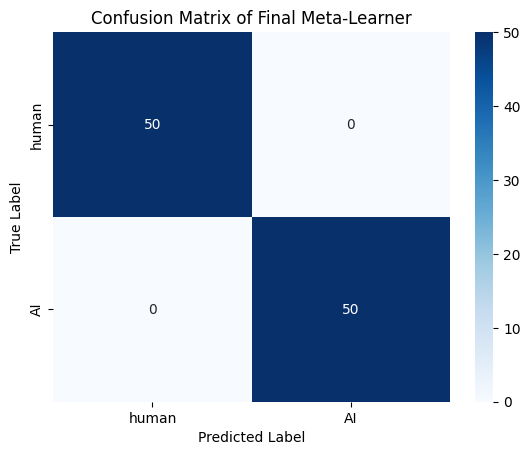

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Contoh label untuk y_test dan prediksi (sesuaikan dengan data Anda)
# y_test = [label human atau AI]
# meta_pred_val = [prediksi model]

# Buat confusion matrix
labels = ['human', 'AI']
conf_matrix = confusion_matrix(y_test, meta_pred_test)

# Visualisasikan confusion matrix dengan label yang sesuai
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix of Final Meta-Learner')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [19]:
# Save CNN model in the recommended .keras format
cnn_model.save('cnn_model.keras')

# Save SVM, RF, and Meta Learner using joblib
import joblib
joblib.dump(svm_model_no_tuning, 'svm_model.pkl')
joblib.dump(rf_model_no_tuning, 'rf_model.pkl')
joblib.dump(meta_learner, 'meta_learner.pkl')

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Contribution of SVM: 2.7167
Contribution of Random Forest: 2.5672
Contribution of CNN: 3.1398


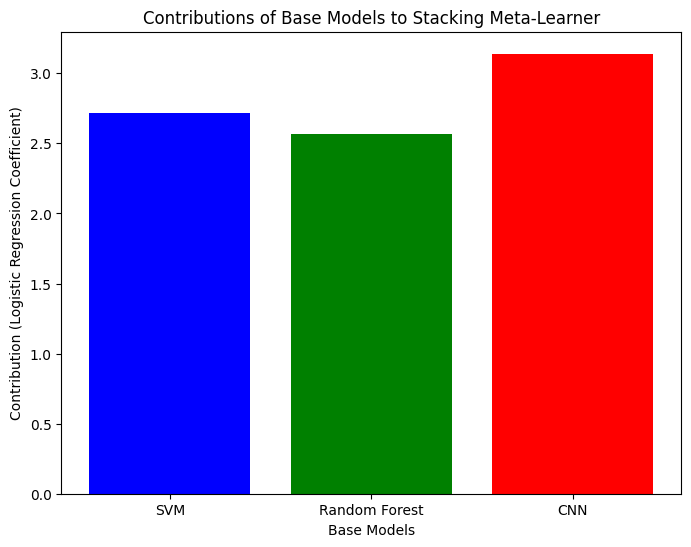

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Setelah meta-learner telah dilatih (LogisticRegression)
# Anda bisa mengambil koefisien dari meta-learner
model_contributions = meta_learner.coef_[0]

# Menampilkan kontribusi dari setiap base model
base_models = ['SVM', 'Random Forest', 'CNN']
for i, contribution in enumerate(model_contributions):
    print(f"Contribution of {base_models[i]}: {contribution:.4f}")

# Visualisasi kontribusi dengan bar chart
plt.figure(figsize=(8, 6))
plt.bar(base_models, model_contributions, color=['blue', 'green', 'red'])
plt.title('Contributions of Base Models to Stacking Meta-Learner')
plt.xlabel('Base Models')
plt.ylabel('Contribution (Logistic Regression Coefficient)')
plt.show()

In [30]:
# Cek bentuk dari data setelah fitur diekstrak
print(X_train.shape)  # Bentuk dari dataset pelatihan

(400, 280)


In [33]:
import librosa

# Muat file audio
y, sr = librosa.load('ai1.wav', sr=None)

# Ekstrak fitur MFCC
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)  # Ubah n_mfcc sesuai dengan kebutuhan

# Lihat bentuk (shape) dari MFCC
print("MFCC shape:", mfccs.shape)

# Ekstrak fitur chroma
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Lihat bentuk (shape) dari Chroma
print("Chroma shape:", chroma.shape)

# Ekstrak fitur Mel-spectrogram
mel = librosa.feature.melspectrogram(y=y, sr=sr)

# Lihat bentuk (shape) dari Mel-spectrogram
print("Mel-spectrogram shape:", mel.shape)

# Ekstrak fitur spectral contrast
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# Lihat bentuk (shape) dari Spectral Contrast
print("Spectral Contrast shape:", contrast.shape)

# Ekstrak fitur tonnetz
tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

# Lihat bentuk (shape) dari Tonnetz
print("Tonnetz shape:", tonnetz.shape)

# Ekstrak fitur ZCR
zcr = librosa.feature.zero_crossing_rate(y)

# Lihat bentuk (shape) dari ZCR
print("ZCR shape:", zcr.shape)

# Ekstrak fitur RMSE
rmse = librosa.feature.rms(y=y)

# Lihat bentuk (shape) dari RMSE
print("RMSE shape:", rmse.shape)


MFCC shape: (40, 1396)
Chroma shape: (12, 1396)
Mel-spectrogram shape: (128, 1396)
Spectral Contrast shape: (7, 1396)
Tonnetz shape: (6, 1396)
ZCR shape: (1, 1396)
RMSE shape: (1, 1396)


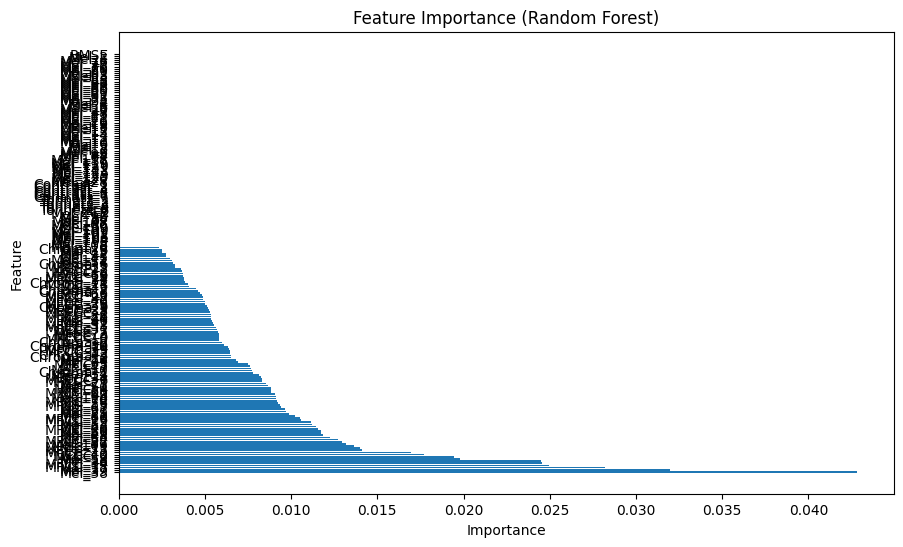

Length of feature_names: 195
Length of adjusted_importances: 195
Statistik Deskriptif untuk Feature Importance:
count    195.000000
mean       0.004739
std        0.006470
min        0.000000
25%        0.000000
50%        0.003126
75%        0.007627
max        0.042800
Name: Importance, dtype: float64

10 Fitur dengan Importances Tertinggi:
     Feature  Importance
89    Mel_38    0.042800
90    Mel_39    0.031972
88    Mel_37    0.028178
12   MFCC_13    0.024983
13   MFCC_14    0.024538
87    Mel_36    0.024511
109   Mel_58    0.019790
110   Mel_59    0.019454
1     MFCC_2    0.017711
39   MFCC_40    0.016955

10 Fitur dengan Importances Terendah:
    Feature  Importance
133  Mel_82         0.0
132  Mel_81         0.0
131  Mel_80         0.0
130  Mel_79         0.0
129  Mel_78         0.0
128  Mel_77         0.0
127  Mel_76         0.0
52    Mel_1         0.0
53    Mel_2         0.0
194    RMSE         0.0
Statistik Deskriptif per Grup Fitur:

MFCC:
Mean: 0.008445
Std: 0.005201
Min:

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importance for Random Forest
importances = rf_model_no_tuning.feature_importances_

# Create a dataframe to store feature importance
# Feature names based on the extracted features
feature_names = [
    # MFCC features (1-40)
    'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10',
    'MFCC_11', 'MFCC_12', 'MFCC_13', 'MFCC_14', 'MFCC_15', 'MFCC_16', 'MFCC_17', 'MFCC_18', 'MFCC_19', 'MFCC_20',
    'MFCC_21', 'MFCC_22', 'MFCC_23', 'MFCC_24', 'MFCC_25', 'MFCC_26', 'MFCC_27', 'MFCC_28', 'MFCC_29', 'MFCC_30',
    'MFCC_31', 'MFCC_32', 'MFCC_33', 'MFCC_34', 'MFCC_35', 'MFCC_36', 'MFCC_37', 'MFCC_38', 'MFCC_39', 'MFCC_40',

    # Chroma features (1-12)
    'Chroma_1', 'Chroma_2', 'Chroma_3', 'Chroma_4', 'Chroma_5', 'Chroma_6', 'Chroma_7', 'Chroma_8', 'Chroma_9', 'Chroma_10', 'Chroma_11', 'Chroma_12',

    # Mel-spectrogram features (1-128)
    'Mel_1', 'Mel_2', 'Mel_3', 'Mel_4', 'Mel_5', 'Mel_6', 'Mel_7', 'Mel_8', 'Mel_9', 'Mel_10',
    'Mel_11', 'Mel_12', 'Mel_13', 'Mel_14', 'Mel_15', 'Mel_16', 'Mel_17', 'Mel_18', 'Mel_19', 'Mel_20',
    'Mel_21', 'Mel_22', 'Mel_23', 'Mel_24', 'Mel_25', 'Mel_26', 'Mel_27', 'Mel_28', 'Mel_29', 'Mel_30',
    'Mel_31', 'Mel_32', 'Mel_33', 'Mel_34', 'Mel_35', 'Mel_36', 'Mel_37', 'Mel_38', 'Mel_39', 'Mel_40',
    'Mel_41', 'Mel_42', 'Mel_43', 'Mel_44', 'Mel_45', 'Mel_46', 'Mel_47', 'Mel_48', 'Mel_49', 'Mel_50',
    'Mel_51', 'Mel_52', 'Mel_53', 'Mel_54', 'Mel_55', 'Mel_56', 'Mel_57', 'Mel_58', 'Mel_59', 'Mel_60',
    'Mel_61', 'Mel_62', 'Mel_63', 'Mel_64', 'Mel_65', 'Mel_66', 'Mel_67', 'Mel_68', 'Mel_69', 'Mel_70',
    'Mel_71', 'Mel_72', 'Mel_73', 'Mel_74', 'Mel_75', 'Mel_76', 'Mel_77', 'Mel_78', 'Mel_79', 'Mel_80',
    'Mel_81', 'Mel_82', 'Mel_83', 'Mel_84', 'Mel_85', 'Mel_86', 'Mel_87', 'Mel_88', 'Mel_89', 'Mel_90',
    'Mel_91', 'Mel_92', 'Mel_93', 'Mel_94', 'Mel_95', 'Mel_96', 'Mel_97', 'Mel_98', 'Mel_99', 'Mel_100',
    'Mel_101', 'Mel_102', 'Mel_103', 'Mel_104', 'Mel_105', 'Mel_106', 'Mel_107', 'Mel_108', 'Mel_109', 'Mel_110',
    'Mel_111', 'Mel_112', 'Mel_113', 'Mel_114', 'Mel_115', 'Mel_116', 'Mel_117', 'Mel_118', 'Mel_119', 'Mel_120',
    'Mel_121', 'Mel_122', 'Mel_123', 'Mel_124', 'Mel_125', 'Mel_126', 'Mel_127', 'Mel_128',

    # Spectral contrast (1-7)
    'Contrast_1', 'Contrast_2', 'Contrast_3', 'Contrast_4', 'Contrast_5', 'Contrast_6', 'Contrast_7',

    # Tonnetz (1-6)
    'Tonnetz_1', 'Tonnetz_2', 'Tonnetz_3', 'Tonnetz_4', 'Tonnetz_5', 'Tonnetz_6',

    # Zero Crossing Rate
    'ZCR',

    # Root Mean Square Energy
    'RMSE'
] # ganti dengan nama fitur sesuai data

# Sesuaikan panjang importances agar sama dengan feature_names
adjusted_importances = importances[:len(feature_names)]  # Potong importances hingga panjangnya sama dengan feature_names

# Buat dataframe untuk menyimpan feature names dan importance
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': adjusted_importances
})

# Sort by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Periksa apakah panjang feature_names dan adjusted_importances sudah sesuai
print("Length of feature_names:", len(feature_names))  # Harus 195
print("Length of adjusted_importances:", len(adjusted_importances))  # Juga harus 195

# Statistik deskriptif untuk feature importance
importance_stats = importances_df['Importance'].describe()

# Output deskriptif
print("Statistik Deskriptif untuk Feature Importance:")
print(importance_stats)

# Menampilkan fitur dengan importances tertinggi dan terendah
top_features = importances_df.head(10)
bottom_features = importances_df.tail(10)

print("\n10 Fitur dengan Importances Tertinggi:")
print(top_features)

print("\n10 Fitur dengan Importances Terendah:")
print(bottom_features)

# Menghitung statistik deskriptif untuk keseluruhan
overall_stats = importances_df['Importance'].describe()

# Mengelompokkan fitur berdasarkan tipe
feature_groups = {
    'MFCC': [f'MFCC_{i}' for i in range(1, 41)],  # MFCC 1-40
    'Chroma': [f'Chroma_{i}' for i in range(1, 13)],  # Chroma 1-12
    'Mel': [f'Mel_{i}' for i in range(1, 129)],  # Mel 1-128
    'Contrast': [f'Contrast_{i}' for i in range(1, 8)],  # Contrast 1-7
    'Tonnetz': [f'Tonnetz_{i}' for i in range(1, 7)],  # Tonnetz 1-6
    'ZCR': ['ZCR'],  # Zero Crossing Rate
    'RMSE': ['RMSE']  # Root Mean Square Energy
}

# Menghitung statistik untuk setiap grup
group_stats = {}
for group, features in feature_groups.items():
    group_importances = importances_df[importances_df['Feature'].isin(features)]['Importance']
    group_stats[group] = {
        'Mean': group_importances.mean(),
        'Std': group_importances.std(),
        'Min': group_importances.min(),
        '25%': group_importances.quantile(0.25),
        '50%': group_importances.median(),
        '75%': group_importances.quantile(0.75),
        'Max': group_importances.max(),
    }

# Menampilkan hasil
print("Statistik Deskriptif per Grup Fitur:")
for group, stats in group_stats.items():
    print(f"\n{group}:")
    for stat_name, value in stats.items():
        print(f"{stat_name}: {value:.6f}")


In [52]:
# Periksa bentuk input yang diharapkan oleh model Anda
cnn_model.summary()

# Asumsikan model Anda mengharapkan bentuk input seperti (224, 224, 3)
# Sesuaikan dummy input agar sesuai dengan bentuk itu
dummy_input = np.random.rand(1, 224, 224, 3)  # Contoh bentuk; sesuaikan dengan input model Anda

# Pastikan nama lapisan benar
layer_name = 'conv2d_1'  # Ganti dengan nama lapisan yang benar

# Panggil model untuk inisialisasi
try:
    _ = cnn_model.predict(dummy_input)
except Exception as e:
    print("Kesalahan saat melakukan prediksi:", e)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 62, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 31, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 64, 64)          │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 64, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 64, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 6, 64, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       6,291,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,331,906 (24.15 MB)

 Trainable params: 6,331,458 (24.15 MB)

 Non-trainable params: 448 (1.75 KB)

Kesalahan saat melakukan prediksi: Graph execution error:

Detected at node convolution defined at (most recent call last):
<stack traces unavailable>
Depth of output must be a multiple of the number of groups: 32 vs 3

Stack trace for op definition: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/

In [ ]:
def predict_single_audio(file_path, cnn_model, svm_model, rf_model, meta_learner, scaler, fixed_length=40):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Extract features from the audio file
    features = extract_features_from_audio(y, sr, fixed_length=fixed_length)

    # Standardize the features
    features = scaler.transform([features])

    # Prepare the input for the CNN model
    features_cnn = features[..., np.newaxis, np.newaxis]

    # Get the prediction probabilities from each model
    svm_pred_proba = svm_model.predict_proba(features)[0][1]  # Probabilitas kelas "AI"
    rf_pred_proba = rf_model.predict_proba(features)[0][1]    # Probabilitas kelas "AI"
    cnn_pred_proba = cnn_model.predict(features_cnn)[0][1]    # Probabilitas kelas "AI"

    # Stack the probabilities for the meta-learner
    stacked_features = np.array([svm_pred_proba, rf_pred_proba, cnn_pred_proba]).reshape(1, -1)

    # Get the final prediction from the meta-learner
    final_pred_proba = meta_learner.predict_proba(stacked_features)
    final_prediction = meta_learner.predict(stacked_features)

    # Output the prediction and probability
    label_map = {0: "Human", 1: "AI"}
    predicted_label = label_map[final_prediction[0]]
    ai_probability = final_pred_proba[0][1] * 100
    human_probability = final_pred_proba[0][0] * 100

    return final_prediction[0], predicted_label, ai_probability, human_probability


In [ ]:
def predict_folder(folder_path, cnn_model, svm_model, rf_model, meta_learner, scaler, fixed_length=40):
    results = []

    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)

            print(f"File: {file_name}")

            # Predict for each audio file
            prediction, label, ai_prob, human_prob = predict_single_audio(
                file_path, cnn_model, svm_model, rf_model, meta_learner, scaler, fixed_length=fixed_length
            )

            # Store the results
            results.append({
                'file_name': file_name,
                'predicted': prediction,
                'label': label,
                'ai_probability': ai_prob,
                'human_probability': human_prob
            })

            # Print the results for each file

            print(f"  Predicted: {prediction}, \"{label}\"")
            print(f"  Probabilities:")
            print(f"    - AI: {ai_prob:.2f}%")
            print(f"    - Human: {human_prob:.2f}%\n")

    return results

In [ ]:
file_path = '/content/drive/MyDrive/dataset/human/human1.wav'
result = predict_single_audio(file_path, cnn_model, svm_model_no_tuning, rf_model_no_tuning, meta_learner, scaler)

print(f"Predicted: {result[0]}, \"{result[1]}\"")
print(f"Probabilities:")
print(f"  - AI: {result[2]:.2f}%")
print(f"  - Human: {result[3]:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted: 0, "Human"
Probabilities:
  - AI: 0.62%
  - Human: 99.38%


In [ ]:
folder_path = '/content/test'
results = predict_folder(folder_path, cnn_model, svm_model_no_tuning, rf_model_no_tuning, meta_learner, scaler)

File: Test(Urdu Clone).wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
  Predicted: 0, "Human"
  Probabilities:
    - AI: 35.03%
    - Human: 64.97%

File: Test(Urdu Real Audio).wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
  Predicted: 0, "Human"
  Probabilities:
    - AI: 1.56%
    - Human: 98.44%

File: test2(clone).wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
  Predicted: 1, "AI"
  Probabilities:
    - AI: 97.88%
    - Human: 2.12%

File: test1(real).wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
  Predicted: 0, "Human"
  Probabilities:
    - AI: 1.55%
    - Human: 98.45%

File: test3(clone).wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
  Predicted: 1, "AI"
  Probabilities:
    - AI: 97.83%
    - Human: 2.17%

File: Test(English Real Audio).wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
  Predicted: 0, "Human"
  Probabilities:
    - AI: 1.77%
    - Human: 98.23%

File: test2(real).wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
  Predicted: 0, "Human"
  Probabilities:
    - AI: 1.49%
    - Human: 98.51%

File: Tes